In [157]:
import pandas as pd
import utils.toolbox as toolbox
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import psycopg2
from joblib import dump



# Extraccion de la Data

In [158]:
# Leer CSV de ventas
df_sales = pd.read_csv("./data/sales.csv")
df_sales

,date,product_id,sales,price,category
0,7/14/2024,1,9,49.96,Mochilas impermeables
1,2/11/2024,2,62,96.06,Overoles de lluvia
2,6/16/2024,3,17,78.56,Sombreros impermeables
3,3/13/2024,4,5,67.89,Conjuntos de lluvia infantiles
4,9/11/2024,3,64,78.56,Sombreros impermeables
...,...,...,...,...,...
995,11/28/2024,6,65,32.48,Ponchos de lluvia
996,12/23/2024,1,27,49.96,Mochilas impermeables
997,5/3/2024,13,6,86.60,Paraguas automáticos
998,7/8/2024,8,73,89.29,Paraguas pequeños


In [159]:
# Llamamos la toolbox de Open-Meteo para obtener los datos de las temperaturas diarias
temperatures = toolbox.get_data()
temperatures.keys()

dict_keys(['time', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum'])

In [160]:
# Convirtiendo la data en un dataframe
df_weather= pd.DataFrame({
    "date": pd.to_datetime(temperatures["time"]),
    "temp_max": temperatures["temperature_2m_max"],
    "temp_min": temperatures["temperature_2m_min"]
})
df_weather.head()

,date,temp_max,temp_min
0,2024-01-01,19.4,11.6
1,2024-01-02,19.4,9.7
2,2024-01-03,19.5,11.6
3,2024-01-04,19.1,8.9
4,2024-01-05,19.6,10.5


In [161]:
# Creando una columna para la temperatura promedio del dia
df_weather["temperature"] = ((df_weather["temp_max"] + df_weather["temp_min"]) / 2).round(1)
df_weather.head()

,date,temp_max,temp_min,temperature
0,2024-01-01,19.4,11.6,15.5
1,2024-01-02,19.4,9.7,14.6
2,2024-01-03,19.5,11.6,15.6
3,2024-01-04,19.1,8.9,14.0
4,2024-01-05,19.6,10.5,15.0


# Union de Dataframes

In [162]:
df_sales.dtypes

date           object
product_id      int64
sales           int64
price         float64
category       object
dtype: object

In [163]:
# Convirtiendo la columna date en tipo datetime
df_sales["date"] = pd.to_datetime(df_sales["date"])
df_weather["date"] = pd.to_datetime(df_weather["date"])

# Formateando la fecha en df_weather
df_weather["date"] = df_weather["date"].dt.strftime("%m/%d/%Y")
df_weather["date"] = pd.to_datetime(df_weather["date"])


In [164]:
df_weather.dtypes

date           datetime64[ns]
temp_max              float64
temp_min              float64
temperature           float64
dtype: object

In [165]:
# Unir ventas + clima
df_final = pd.merge(df_sales, df_weather[["date", "temperature"]], on="date", how="left")
df_final.head()

,date,product_id,sales,price,category,temperature
0,2024-07-14,1,9,49.96,Mochilas impermeables,14.2
1,2024-02-11,2,62,96.06,Overoles de lluvia,15.6
2,2024-06-16,3,17,78.56,Sombreros impermeables,13.6
3,2024-03-13,4,5,67.89,Conjuntos de lluvia infantiles,15.8
4,2024-09-11,3,64,78.56,Sombreros impermeables,14.6


# Limpieza de datos

In [166]:
df_final.describe()

,date,product_id,sales,price,temperature
count,1000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-06-28 02:22:33.600000,12.694000,51.786000,56.283990,14.819300
min,2024-01-01 00:00:00,1.000000,1.000000,21.650000,12.600000
25%,2024-03-28 00:00:00,7.000000,27.000000,34.670000,14.200000
50%,2024-06-25 00:00:00,12.000000,53.000000,52.260000,14.800000
75%,2024-09-29 00:00:00,19.000000,76.000000,76.650000,15.400000
max,2024-12-30 00:00:00,25.000000,100.000000,97.590000,17.700000
std,NaN,7.108227,29.092758,23.058458,0.903102


In [167]:
# Tipos de las variables
df_final.dtypes

date           datetime64[ns]
product_id              int64
sales                   int64
price                 float64
category               object
temperature           float64
dtype: object

In [168]:
# examinando valores nulos
df_final.isnull().sum()

date           0
product_id     0
sales          0
price          0
category       0
temperature    0
dtype: int64

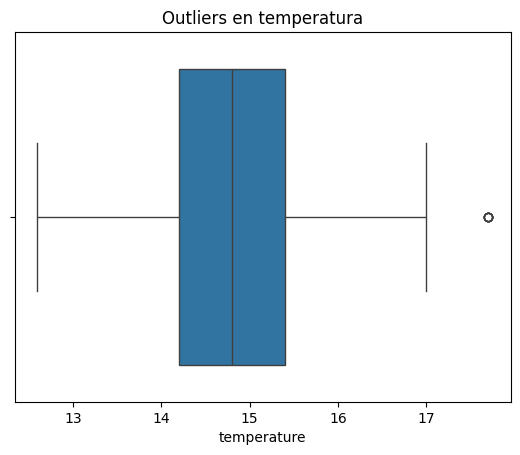

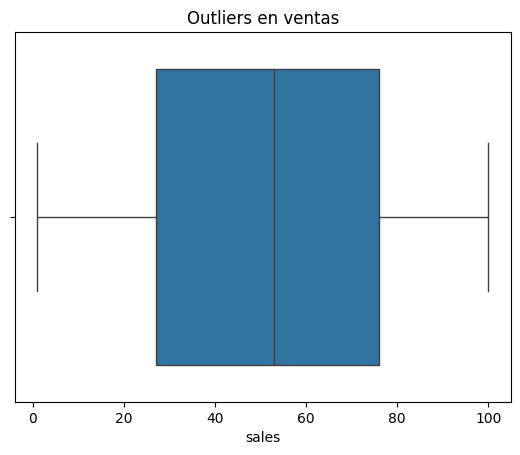

In [169]:
# Examinando outliers
sns.boxplot(data=df_final, x="temperature")
plt.title("Outliers en temperatura")
plt.show()

sns.boxplot(data=df_final, x="sales")
plt.title("Outliers en ventas")
plt.show()

In [170]:
# Outliers para temperature
Q1 = df_final["temperature"].quantile(0.25)
Q3 = df_final["temperature"].quantile(0.75)
IQR = Q3 - Q1

# Límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers_temp = df_final[
    (df_final["temperature"] < lower_bound) |
    (df_final["temperature"] > upper_bound)
]

print(outliers_temp[["date", "temperature"]])

          date  temperature
200 2024-01-29         17.7
283 2024-01-29         17.7
346 2024-01-29         17.7
356 2024-01-29         17.7
419 2024-01-29         17.7
912 2024-01-29         17.7


Se identificaron valores atípicos en la columna temperature (17.7 °C repetido 6 veces).
Dado que este valor es realista para la ubicación y no representa un error de medición, se mantuvo en el dataset sin modificaciones.

# Comparando modelos

In [171]:
# === Procesar columna date ===
df_modelo = df_final.copy()

df_modelo["day_of_week"] = df_final["date"].dt.dayofweek
df_modelo["month"] = df_final["date"].dt.month
df_modelo["day_of_year"] = df_final["date"].dt.dayofyear

In [172]:
# === Codificar category ===
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
category_encoded = encoder.fit_transform(df_modelo[["category"]])
category_df = pd.DataFrame(category_encoded, columns=encoder.get_feature_names_out(["category"]))
df_modelo = pd.concat([df_modelo, category_df], axis=1)

# === Variables y target ===
feature_cols = ["temperature", "price", "day_of_week", "month", "day_of_year"] + list(category_df.columns)
X = df_modelo[feature_cols]
y = df_modelo["sales"]

In [173]:
# === Dividir en entrenamiento y prueba ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========= Modelo 1: Regresión Lineal =========
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Métricas Regresión Lineal
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

# ========= Modelo 2: XGBoost =========
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Métricas XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# ========= Comparativa =========
metrics_df = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "XGBoost"],
    "MAE": [mae_lr, mae_xgb],
    "RMSE": [rmse_lr, rmse_xgb],
    "R²": [r2_lr, r2_xgb]
})

print("\n=== Comparativa de Modelos ===")
print(metrics_df)

# ========= Seleccionar mejor modelo =========
if mae_xgb < mae_lr:
    print("Usando XGBoost para predicciones finales.")
    df_final["sales_prediction"] = xgb_model.predict(X)
else:
    print("Usando Regresión Lineal para predicciones finales.")
    df_final["sales_prediction"] = lr_model.predict(X)



=== Comparativa de Modelos ===
             Modelo        MAE       RMSE        R²
0  Regresión Lineal  24.982101  29.719818 -0.057547
1           XGBoost  26.288607  32.228179 -0.243595
Usando Regresión Lineal para predicciones finales.


In [174]:
dump(xgb_model, "./models/xgb_model.joblib")
dump(lr_model, "./models/lr_model.joblib")

print("Modelos exportados correctamente")

Modelos exportados correctamente


In [175]:
df_final

,date,product_id,sales,price,category,temperature,sales_prediction
0,2024-07-14,1,9,49.96,Mochilas impermeables,14.2,49.107625
1,2024-02-11,2,62,96.06,Overoles de lluvia,15.6,48.549167
2,2024-06-16,3,17,78.56,Sombreros impermeables,13.6,52.532848
3,2024-03-13,4,5,67.89,Conjuntos de lluvia infantiles,15.8,48.102440
4,2024-09-11,3,64,78.56,Sombreros impermeables,14.6,56.358862
...,...,...,...,...,...,...,...
995,2024-11-28,6,65,32.48,Ponchos de lluvia,14.3,53.513378
996,2024-12-23,1,27,49.96,Mochilas impermeables,14.1,48.191908
997,2024-05-03,13,6,86.60,Paraguas automáticos,15.9,54.243372
998,2024-07-08,8,73,89.29,Paraguas pequeños,13.4,49.973588


# Conectando a la BD

In [176]:

# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Leer credenciales
USER = os.getenv("PG_USER")
PASSWORD = os.getenv("PG_PASSWORD")
HOST = os.getenv("PG_HOST")
PORT = os.getenv("PG_PORT")
DB = os.getenv("PG_DB")

# Crear conexión a PostgreSQL
engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# Subir datos a la tabla sales_predictions
df_final.to_sql("sales_predictions", engine, if_exists="replace", index=False)

print("Datos subidos correctamente a PostgreSQL en la tabla 'sales_predictions'")


Datos subidos correctamente a PostgreSQL en la tabla 'sales_predictions'


In [177]:
# Ajustar estructura de la tabla
with engine.connect() as conn:
    conn.execute(text("""
        -- Agregar columna id si no existe
        DO $$
        BEGIN
            IF NOT EXISTS (
                SELECT 1
                FROM information_schema.columns
                WHERE table_name = 'sales_predictions'
                AND column_name = 'id'
            ) THEN
                ALTER TABLE sales_predictions ADD COLUMN id SERIAL PRIMARY KEY;
            END IF;
        END$$;

        -- Asegurar tipos de datos correctos
        ALTER TABLE sales_predictions
        ALTER COLUMN date TYPE DATE USING date::DATE,
        ALTER COLUMN product_id TYPE INT USING product_id::INTEGER,
        ALTER COLUMN sales TYPE INT USING sales::INTEGER,
        ALTER COLUMN price TYPE DOUBLE PRECISION USING price::DOUBLE PRECISION,
        ALTER COLUMN category TYPE VARCHAR(50),
        ALTER COLUMN temperature TYPE DOUBLE PRECISION USING temperature::DOUBLE PRECISION,
        ALTER COLUMN sales_prediction TYPE DOUBLE PRECISION USING sales_prediction::DOUBLE PRECISION;
    """))
    conn.commit()

print("Estructura de la tabla ajustada")

Estructura de la tabla ajustada


In [178]:
SP_USER = os.getenv("SUPABASE_USER")        
SP_PASSWORD = os.getenv("SUPABASE_PASSWORD")
SP_HOST = os.getenv("SUPABASE_HOST")         
SP_PORT = os.getenv("SUPABASE_PORT")         
SP_DB = os.getenv("SUPABASE_DB")    

# Cargar variables de entorno
load_dotenv()

# Conexión Supabase
# Crear conexión a PostgreSQL en Supabase usando IPv4
engine_sp = create_engine(
    f"postgresql+psycopg2://{SP_USER}:{SP_PASSWORD}@{SP_HOST}:{SP_PORT}/{SP_DB}"
)

In [179]:
# Crear la tabla si no existe
with engine_sp.connect() as conn:
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS sales_predictions (
            id SERIAL PRIMARY KEY,
            date DATE,
            product_id INT,
            sales INT,
            price DOUBLE PRECISION,
            category VARCHAR(50),
            temperature DOUBLE PRECISION,
            sales_prediction DOUBLE PRECISION
        );
    """))
    conn.commit()

In [180]:
# Subir datos
with engine.begin() as conn:
    df_final.to_sql("sales_predictions", engine, if_exists="replace", index=False, method="multi")

print("Datos subidos a Supabase exitosamente.")

Datos subidos a Supabase exitosamente.


In [181]:
# Cargando variables de entorno
SP_USER = os.getenv("SUPABASE_USER")        
SP_PASSWORD = os.getenv("SUPABASE_PASSWORD")
SP_HOST = os.getenv("SUPABASE_HOST")         
SP_PORT = os.getenv("SUPABASE_PORT")         
SP_DB = os.getenv("SUPABASE_DB")             

In [182]:
# Conectando con Supabase
conn = psycopg2.connect(
    host=SP_HOST,
    dbname=SP_DB,
    user=SP_USER,
    password=SP_PASSWORD,
    port=SP_PORT,
    sslmode='require'
)
cur = conn.cursor()

In [183]:
# Cargando datos a Supabase

tuplas = [tuple(x) for x in df_final.to_numpy()]
cols = ','.join(df_final.columns)

query = f"INSERT INTO sales_predictions ({cols}) VALUES %s"
psycopg2.extras.execute_values(cur, query, tuplas)
conn.commit()

cur.close()
conn.close()

print("Datos insertados correctamente en Supabase en la tabla 'sales_predictions'.")

Datos insertados correctamente en Supabase en la tabla 'sales_predictions'.


In [184]:
# cargando el query para calcular el erro medio agrupado por categoria
with open("./utils/queries.sql", "r") as f:
    query = f.read()

df_error = pd.read_sql(query, engine)


In [185]:
df_error

,category,avg_error
0,Chalecos repelentes al agua,24.389282
1,Fundas para mochilas,23.249353
2,Impermeables largos,22.655396
3,Leggings repelentes,27.212707
4,Botas infantiles,22.356300
5,Paraguas automáticos,22.308746
6,Bolsos repelentes,22.855255
7,Fundas para cochecitos,22.019408
8,Bufandas sintéticas,26.145217
9,Abrigos con capucha,25.076098
